In [2]:
import glob
from PIL import Image
import numpy as np
from matplotlib import cm
from tqdm.notebook import tqdm, tnrange
from IPython.display import display

In [3]:
# Parameters

z_r = 17.0
z_a = 6.5
z_b = 15.0
z_f = 15.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / z_r
size_b = size_r * z_b / z_r

resolution_r = 128
low_resolution_a = 4
low_resolution_b = 32
high_resolution_a = 16
high_resolution_b = 512

In [4]:
# Basic coordinate manipulation functions.

def compute_coordinates(resolution, size):
    """Return an array of shape (resolution) containing the coordinates of a sampling lattice."""
    pitch = size / resolution
    indices = np.arange(resolution)
    return (indices - (resolution - 1)/2) * pitch

def compute_intervals(resolution, size):
    """Return an array of shape (resolution, 2) containing the boundaries of each sampling region."""
    pitch = size / resolution
    indices = np.arange(resolution)
    lower_boundaries = indices * pitch - size/2
    upper_boundaries = lower_boundaries + pitch
    return np.stack([lower_boundaries, upper_boundaries], axis=-1)

In [5]:
# Anti-aliased circle generation functions

def semicircle(x):
    """Return the positive y coordinate associated to an x coordinate in a unit circle."""
    return np.sqrt(1.0 - np.square(x))

def semicircle_integral(x):
    """Return the indefinite integral at x of the semicircle function."""
    return (np.sqrt(1.0 - np.square(x)) * x + np.arcsin(x))/2

def semicircle_box_area(horizontal_intervals, vertical_intervals):
    """Return the area of the intersection of a box against the unit semicircle."""
    # Restrain the vertical intervals to the positive space
    vertical_intervals = np.maximum(vertical_intervals, 0.0)

    # Reshape to (idx_h, idx_v, Left|Right, Lower|Upper)
    horizontal_intervals = horizontal_intervals[:, np.newaxis, :, np.newaxis]
    vertical_intervals   =   vertical_intervals[np.newaxis, :, np.newaxis, :]

    # Compute horizontal intervals defined by the intersection of each vertical coordinate with the circle
    circle_intervals = semicircle(vertical_intervals)

    # Clamp the horizontal intervals to the according column regions given by the circle horizontal intervals
    horizontal_intervals = np.clip(horizontal_intervals, -circle_intervals, circle_intervals)

    # Compute the indefinite integral at each horizontal interval boundary
    integrals = semicircle_integral(horizontal_intervals)

    #
    return np.tensordot(integrals - horizontal_intervals * vertical_intervals, [[-1.0, 1.0], [1.0, -1.0]])

def circle_box_area(horizontal_intervals, vertical_intervals):
    """Return the area of the intersection of a box against the unit circle."""
    # Split vertical intervals into upper and lower halves
    vertical_intervals_above = np.maximum(vertical_intervals, 0.0)
    vertical_intervals_below = np.maximum(-np.flip(vertical_intervals, axis=-1), 0.0)

    # Compute semicircle-box intersection areas
    areas_above = semicircle_box_area(horizontal_intervals, vertical_intervals_above)
    areas_below = semicircle_box_area(horizontal_intervals, vertical_intervals_below)

    # Return the sum of the upper and lower halves
    return areas_above + areas_below

In [6]:
# Tensor generation functions

def compute_intervals_at_pupil(resolution_r, size_r, z_r,
                               resolution_a, size_a, z_a,
                               resolution_b, size_b, z_b,
                                     pupil_diameter, z_f):
    """Return the intersections of the 1-dim intervals of each display plane projected at the pupil plane."""
    # Scale pupil to the unit circle
    size_r = size_r * 2 / pupil_diameter
    size_a = size_a * 2 / pupil_diameter
    size_b = size_b * 2 / pupil_diameter

    # Compute coordinates and intervals with shape (idx_r, idx_a, idx_b, Lower|Upper)
    coordinates_r = compute_coordinates(resolution_r, size_r)[:, np.newaxis, np.newaxis, np.newaxis]
    intervals_a = compute_intervals(resolution_a, size_a)[np.newaxis, :, np.newaxis, :]
    intervals_b = compute_intervals(resolution_b, size_b)[np.newaxis, np.newaxis, :, :]

    # Project intervals to the pupil plane
    projected_a = (intervals_a - coordinates_r * z_a/z_r) / (1.0 - z_a/z_f)
    projected_b = (intervals_b - coordinates_r * z_b/z_r) / (1.0 - z_b/z_f)

    # Return the intersections of plane B intervals against plane A intervals against the unit box
    return np.clip(np.clip(projected_a, -1.0, 1.0), projected_b[..., 0, np.newaxis], projected_b[..., 1, np.newaxis])

def compute_imaging_tensor(resolution_r, size_r, z_r,
                           resolution_a, size_a, z_a,
                           resolution_b, size_b, z_b,
                                 pupil_diameter, z_f):
    """Return a sparse tensor that maps the contribution of each 4-dim light field interval (x_a, y_a, x_b, y_b) to each 2-dim retina sample (x_r, y_r)"""
    # Compute the 1-dim intersection intervals over the pupil plane
    intersection_intervals = compute_intervals_at_pupil(resolution_r, size_r, z_r,
                                                        resolution_a, size_a, z_a,
                                                        resolution_b, size_b, z_b,
                                                              pupil_diameter, z_f)
    
    # Indices of nonempty 1-dim intersection intervals
    idx_r, idx_a, idx_b = np.nonzero(intersection_intervals[..., 1] - intersection_intervals[..., 0])

    # Nonempty 1-dim intersection intervals with shape (idx, Lower|Upper)
    nonempty_intervals = intersection_intervals[idx_r, idx_a, idx_b]

    # Compute circle-box intersection areas
    areas = circle_box_area(nonempty_intervals, nonempty_intervals)

    print('areas', areas.shape)

    # Index of nonzero areas
    idx_h, idx_v = np.nonzero(areas)

    print('idx_h', idx_h.shape)
    print('idx_v', idx_v.shape)

    # Sparse indices and values
    sparse_indices = np.vstack([idx_r[idx_h], idx_r[idx_v], idx_a[idx_h], idx_a[idx_v], idx_b[idx_h], idx_b[idx_v]])
    sparse_values = areas[idx_h, idx_v]

    print('sparse_indices', sparse_indices.shape)
    print('sparse_values', sparse_values.shape)

    # Return the sparse tensor
    tensor_shape = (resolution_r, resolution_r, resolution_a, resolution_a, resolution_b, resolution_b)
    return sparse.COO(sparse_indices, sparse_values, shape=tensor_shape)

In [7]:
# Light field downsampling functions

def naive_downsampling(light_field, resolution_a, resolution_b):
  indices_a = np.arange(resolution_a)
  indices_b = np.arange(resolution_b)
  shifted_a = indices_a - int(resolution_a/2)
  shifted_b = indices_b - int(resolution_b/2)
  lpf_a = np.fft.ifftshift(shifted_a)
  lpf_b = np.fft.ifftshift(shifted_b)
  spectrum = np.fft.fftn(light_field)
  downsampled = np.real(np.fft.ifftn(spectrum[np.ix_(lpf_a, lpf_a, lpf_b, lpf_b)]))
  return downsampled / np.amax(downsampled)

In [8]:
# Image and light field visualization functions

def display_image(values, color_map=None):
  color_values = cm.get_cmap(color_map)(values/np.amax(values))
  uint8_values = (color_values * 255).astype(np.uint8)
  display(Image.fromarray(uint8_values).transpose(Image.ROTATE_90))

def display_light_field(light_field, color_map=None):
    tiled_light_field = light_field.swapaxes(1, 2).reshape((np.prod(light_field.shape[0::2]), -1))
    display_image(tiled_light_field, color_map)

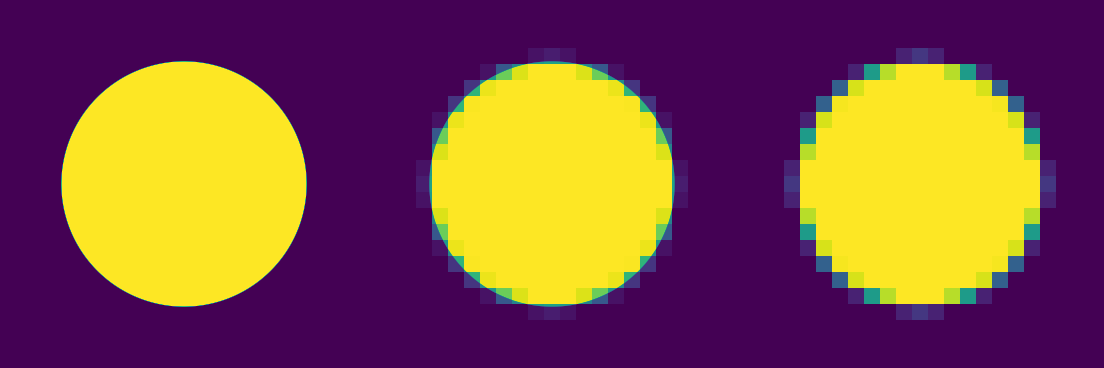

In [9]:
# Anti-aliased circle generation test

test_resolution = 23
test_size = 3.0

high_res_intervals = np.clip(compute_intervals(test_resolution*16, test_size), -1.0, 1.0)
high_res_image = circle_box_area(high_res_intervals, high_res_intervals)

low_res_intervals = np.clip(compute_intervals(test_resolution, test_size), -1.0, 1.0)
low_res_image = np.kron(circle_box_area(low_res_intervals, low_res_intervals), np.ones((16, 16)) / 16**2)

display_image(np.array([*high_res_image, *(high_res_image + low_res_image)*0.5, *low_res_image]))

In [10]:
high_res_tensor = compute_imaging_tensor(resolution_r, size_r, z_r,
                                    high_resolution_a, size_a, z_a,
                                    high_resolution_b, size_b, z_b,
                                               pupil_diameter, z_f)

print('High resolution tensor:', high_res_tensor)
print('Size: {:.2f} GiB'.format(high_res_tensor.nbytes / 2**30))

<ipython-input-6-bf880abd225f>:20: RuntimeWarning: divide by zero encountered in true_divide
  projected_b = (intervals_b - coordinates_r * z_b/z_r) / (1.0 - z_b/z_f)
<ipython-input-6-bf880abd225f>:20: RuntimeWarning: invalid value encountered in true_divide
  projected_b = (intervals_b - coordinates_r * z_b/z_r) / (1.0 - z_b/z_f)
<ipython-input-6-bf880abd225f>:37: RuntimeWarning: invalid value encountered in subtract
  idx_r, idx_a, idx_b = np.nonzero(intersection_intervals[..., 1] - intersection_intervals[..., 0])
<ipython-input-5-a1d794566152>:5: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1.0 - np.square(x))


MemoryError: Unable to allocate 32.0 TiB for an array with shape (1048417, 1048417, 2, 2) and data type float64

In [11]:
low_res_tensor = compute_imaging_tensor(resolution_r, size_r, z_r,
                                    low_resolution_a, size_a, z_a,
                                    low_resolution_b, size_b, z_b,
                                              pupil_diameter, z_f)

print('Low resolution tensor:', low_res_tensor)
print('Size: {:.2f} GiB'.format(low_res_tensor.nbytes / 2**30))

<ipython-input-6-bf880abd225f>:20: RuntimeWarning: divide by zero encountered in true_divide
  projected_b = (intervals_b - coordinates_r * z_b/z_r) / (1.0 - z_b/z_f)
<ipython-input-6-bf880abd225f>:37: RuntimeWarning: invalid value encountered in subtract
  idx_r, idx_a, idx_b = np.nonzero(intersection_intervals[..., 1] - intersection_intervals[..., 0])
<ipython-input-5-a1d794566152>:5: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1.0 - np.square(x))


In [ ]:
high_res_lf = np.zeros((17, 17, 1024, 1024))

dataset_path = "datasets/tarot/"
path_length = len(dataset_path)

for image_path in tqdm(glob.glob(dataset_path + "*.png"), leave=False):
    i_a = int(image_path[path_length+7:path_length+9])
    j_a = int(image_path[path_length+4:path_length+6])
    high_res_lf[i_a, j_a] = np.array(Image.open(image_path).convert('L').transpose(Image.ROTATE_270))

display_image(high_res_lf[8, 8])

In [ ]:
low_res_lf = naive_downsampling(high_res_lf, low_resolution_a, low_resolution_b)
display_light_field(low_res_lf)

In [ ]:
high_res_image = sparse.tensordot(high_res_tensor, high_res_lf, 4)
display_image(high_res_image)

In [ ]:
low_res_image = sparse.tensordot(low_res_tensor, low_res_lf, 4)
display_image(low_res_image)